In [4]:
import matplotlib.pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap
import mne
import numpy as np
from pathlib import Path
import pandas as pd
from tqdm import tqdm


In [5]:

dir_data = Path(r'W:\source_projects\epoc_cn\sourcedata') # update the path to your folder

# find all vdhr files in any subfolder
fnames_bv_all = list(dir_data.glob('**/*.vhdr'))

# prelocate dataframe with channel names (0-127) as and impedances,
# column should be the time of the recordings
impedances_df = pd.DataFrame(columns=range(125))

# add date column
impedances_df['date'] = None



In [6]:

# loop over all vdhr files and save the plots for the impedance
for fname_bv in tqdm(fnames_bv_all):
    
    fname_bv = str(fname_bv)
    raw = mne.io.read_raw_brainvision(fname_bv, verbose=False, preload=True);
    # check if bva got the correct channel locations
    chns_layout = raw.get_montage()
    
    # get channel names
    ch_names = raw.ch_names
    
    # get impedances from eeg channels
    eeg_chs = mne.pick_types(raw.info, meg=False, eeg=True)
    all_imp = [info["imp"] for i, info in raw.impedances.items() if i != "ECG" or i != "33"]

    # typically impedances < 25 kOhm are acceptable for active systems and
    # impedances < 5 kOhm are desirable for a passive system
    impedances = [imp for imp in all_imp if not np.isnan(imp)]
    
    # add the impedances to the dataframe as one row
    impedances_df = pd.concat([impedances_df, pd.Series(impedances).to_frame().T], ignore_index=True)
    
    # add the date of the recording as a column name
    date_recording = raw.info['meas_date']
    impedances_df.loc[impedances_df.index[-1], 'date'] = date_recording


  0%|          | 0/80 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_40804\3493064948.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  impedances_df = pd.concat([impedances_df, pd.Series(impedances).to_frame().T], ignore_index=True)
100%|██████████| 80/80 [02:31<00:00,  1.89s/it]


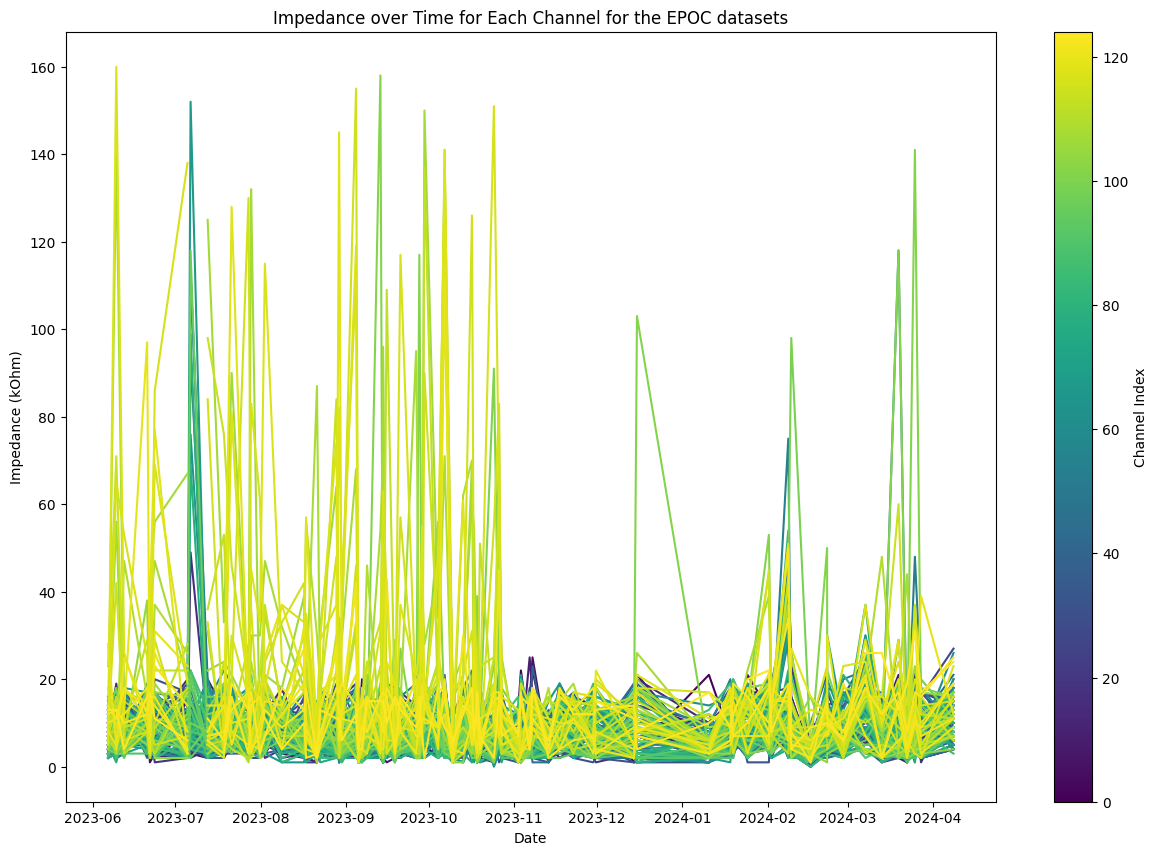

In [11]:

# order df by date
impedances_df = impedances_df.sort_values('date')

# drop row if more than half are nan values
impedances_df = impedances_df.dropna(thresh=impedances_df.shape[1]//2)

# plot the impedances against date for each channel
fig, ax = plt.subplots(figsize=(15, 10))
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=0, vmax=124)

for i in range(125):
    ax.plot(impedances_df['date'], impedances_df[i], label=f'Channel {i}', color=cmap(norm(i)))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Channel Index')

ax.set_xlabel('Date')
ax.set_ylabel('Impedance (kOhm)')
ax.set_title('Impedance over Time for Each Channel for the EPOC datasets')
plt.show()

In [12]:
# Get today's date
today_date = pd.Timestamp.today().strftime('%Y-%m-%d')

# Define the filename with today's date
filename = f'impedance_checks/impedances_EPOC_{today_date}.csv'

# Save the dataframe to a CSV file
impedances_df.to_csv(filename, index=False)